This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

In [1]:
from tensorflow import keras
#!pip install tensorflow[and-cuda]
import tensorflow as tf

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.0


In [14]:
!pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 3.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/7.8 MB 2.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.8 MB 2.3 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/7.8 MB 2.4 MB/s eta 0:00:03
   ------------ --------------------------- 2.4/7.8 MB 2.4 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/7.8 MB 2.3 MB/s eta 0:00:03
   ---------------- ----------------------- 3.1/7.8 MB 2.3 MB/s eta 0:00:03
   ------------------ --------------------- 3.7/7.8 MB 2.2 MB/s eta 0:00:02
   --------------------- ------------------ 4.2/7.8 MB 2.2 MB/s eta 0:00:02
   ------------------------ --------------- 4.7/7.8 MB 2.3 MB/s eta 0:00:02
   -------------------------- -----------

# Introduction to deep learning for computer vision

### Downloading the data

**Reading in training, validation, test datasets**

In [5]:
!pip install opendatasets
!pip install pandas

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105797 sha256=f7b0c3fe872283a6f1692b459ec3bb909aa2f7ceb455672f36c11a450cc59958
  Stored in directory: c:\users\ola\appdata\local\pip\cache\wheels\ff\55\fb\b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 2.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.6 MB 2.8 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.6 MB 4.2 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/11.6 MB 4.5 MB/s eta 0:00:02
   ----------------- ---------------------- 5.0/11.6 MB 4.9 MB/s eta 0:00:02
   -------------------- ------------------- 6.0/11.6 MB 5.1 MB/s eta 0:00:02
   ----------------------- ---------------- 6.8/11.6 MB 4.8 M

In [1]:
import opendatasets as od 
import pandas 

od.download( 
	"https://www.kaggle.com/c/dogs-vs-cats") 


100%|██████████| 812M/812M [03:55<00:00, 3.62MB/s] 



Extracting archive .\dogs-vs-cats/dogs-vs-cats.zip to .\dogs-vs-cats


In [7]:
#from google.colab import files
#files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c dogs-vs-cats

In [8]:
import zipfile
!unzip -qq dogs-vs-cats.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!unzip -qq train.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats_small500")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("train_dataset", start_index=0, end_index=500)
make_subset("validation_dataset", start_index=500, end_index=750)
make_subset("test_dataset", start_index=750, end_index=1000)

In [2]:
import os, shutil, pathlib
new_base_dir = pathlib.Path("dogs_vs_cats_small5000")


### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_dataset",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_dataset",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_dataset",
    image_size=(180, 180),
    batch_size=32)


Found 10000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


Note the difference in the number of files for the testing dataset.

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))

dataset = tf.data.Dataset.from_tensor_slices(random_numbers)


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [10]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 24ms/step


In [11]:
train_features.shape

(1000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [12]:
from tensorflow.keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.h5",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
32/32 [==============================] - 1s 15ms/step - loss: 18.0143 - accuracy: 0.9170 - val_loss: 5.9073 - val_accuracy: 0.9540
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 3.0861 - accuracy: 0.9760 - val_loss: 7.0373 - val_accuracy: 0.9520
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.9827 - accuracy: 0.9860 - val_loss: 18.4221 - val_accuracy: 0.9300
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 2.6491 - accuracy: 0.9850 - val_loss: 7.4701 - val_accuracy: 0.9560
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 1.6144 - accuracy: 0.9890 - val_loss: 9.3456 - val_accuracy: 0.9520
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.1919 - accuracy: 0.9980 - val_loss: 8.2908 - val_accuracy: 0.9540
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0498 - accuracy: 0.9980 - val_loss: 9.7949 - val_accuracy: 0.9560
Epoch 8/20
32/32 

**Plotting the results**

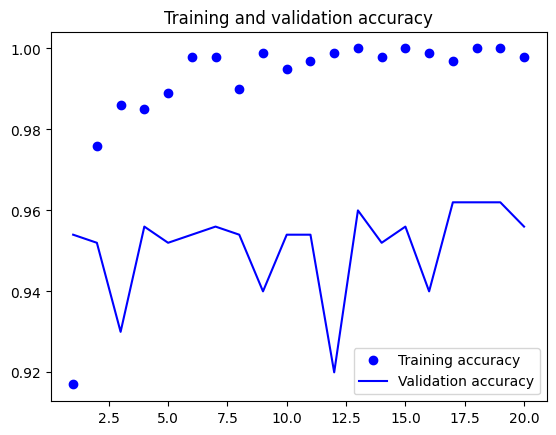

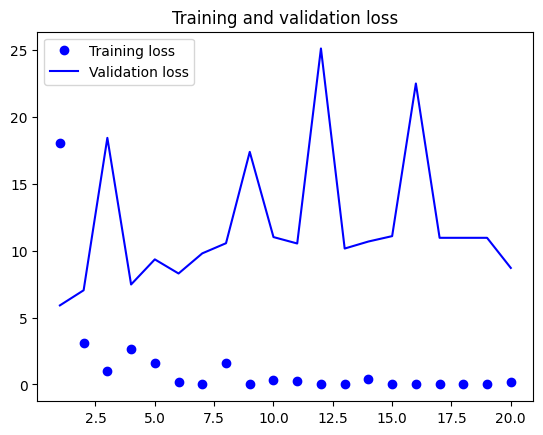

In [15]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [6]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [7]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [8]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [9]:
from tensorflow.keras import layers
from tensorflow import keras
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
313/313 [==============================] - 77s 222ms/step - loss: 10.2867 - accuracy: 0.9358 - val_loss: 7.3809 - val_accuracy: 0.9760
Epoch 2/50
313/313 [==============================] - 65s 207ms/step - loss: 5.2614 - accuracy: 0.9560 - val_loss: 4.8603 - val_accuracy: 0.9760
Epoch 3/50
313/313 [==============================] - 71s 226ms/step - loss: 2.7525 - accuracy: 0.9598 - val_loss: 2.6414 - val_accuracy: 0.9720
Epoch 4/50
313/313 [==============================] - 73s 233ms/step - loss: 1.3835 - accuracy: 0.9633 - val_loss: 1.0522 - val_accuracy: 0.9800
Epoch 5/50
313/313 [==============================] - 70s 224ms/step - loss: 0.7466 - accuracy: 0.9628 - val_loss: 1.1862 - val_accuracy: 0.9700
Epoch 6/50
313/313 [==============================] - 72s 230ms/step - loss: 0.6210 - accuracy: 0.9664 - val_loss: 1.1960 - val_accuracy: 0.9700
Epoch 7/50
313/313 [==============================] - 72s 230ms/step - loss: 0.5776 - accuracy: 0.9682 - val_loss: 1.5473 - val_a

**Evaluating the model on the test set**

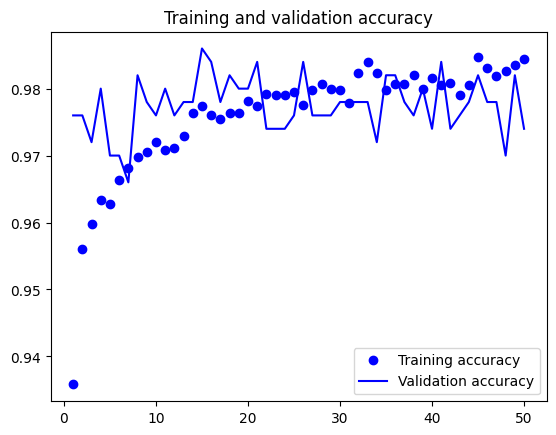

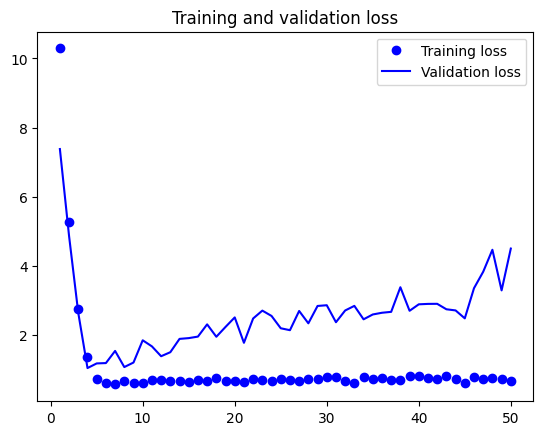

In [11]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 3s 125ms/step - loss: 1.0341 - accuracy: 0.9680
Test accuracy: 0.968


### Fine-tuning a pretrained model

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [16]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 192ms/step - loss: 3.4070 - accuracy: 0.9660 - val_loss: 2.6511 - val_accuracy: 0.9720
Epoch 2/30
63/63 [==============================] - 12s 195ms/step - loss: 1.9561 - accuracy: 0.9795 - val_loss: 2.2777 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 12s 193ms/step - loss: 1.1596 - accuracy: 0.9835 - val_loss: 2.5035 - val_accuracy: 0.9700
Epoch 4/30
63/63 [==============================] - 12s 193ms/step - loss: 1.0657 - accuracy: 0.9855 - val_loss: 2.1700 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 12s 194ms/step - loss: 0.6263 - accuracy: 0.9860 - val_loss: 1.9684 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 12s 194ms/step - loss: 0.9286 - accuracy: 0.9870 - val_loss: 2.1711 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 12s 193ms/step - loss: 0.7878 - accuracy: 0.9855 - val_loss: 2.2920 - val_accuracy: 0.9760

In [18]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 60ms/step - loss: 2.1591 - accuracy: 0.9760
Test accuracy: 0.976


## Summary